# TEST

In [89]:
from atlite.datasets.era5 import retrieve_data, _rename_and_clean_coords, retrieval_times, _area
from joblib import Parallel
import xarray as xr
import atlite
import logging
import cdsapi
from cartopy.io import shapereader
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
logging.basicConfig(level=logging.INFO)

import geopandas as gpd
import pandas as pd

from pyesgf.logon import LogonManager

lm = LogonManager()
lm.logoff()
lm.is_logged_on()

USERNAME='guillerv'
OPENID = f'https://esgf-data.dkrz.de/esgf-idp/openid/guillerv'
lm.logon_with_openid(openid=OPENID, password=None, bootstrap=True)
lm.is_logged_on()

# Shape file for Chile - boundary
Chile = gpd.read_file('Chile.geojson')
Chile = Chile.set_index('region')
bounds = Chile.unary_union.buffer(1).bounds

# set lat and lon
x1 = bounds[0]
y1 = bounds[1]
x2 = bounds[2]
y2 = bounds[3]


cutout_era5_test = atlite.Cutout(path="Chile_test.nc",
                            module="era5", 
                            x=slice(x1,x2), 
                            y=slice(y1,y2), 
                            time=slice("2021-10-01","2022-04-01"))


cutout_era5_test.prepare()

esgf_params = {
   'data_node': 'esgf.ceda.ac.uk',
   'source_id': 'HadGEM3-GC31-MM',
   'variant_label':'r1i1p1f3',
   'experiment_id': 'ssp126',
   'project' : 'CMIP6'}


cutout_cmip_test = atlite.Cutout(path="cmip_chile_test.nc",
                            module=["cmip"], 
                            x=slice(x1,x2), 
                            y=slice(y1,y2), 
                            time=slice("2021-10-01","2022-04-01"), 
                            esgf_params=esgf_params, 
                            dt='3H', dx=1,dy=1)


cutout_cmip_test.prepare()

/media/guillerv/Windows/environments/CMIP6/lib/python3.10/site-packages/atlite/cutout.py:196: UserWarning: Arguments module, x, y, time are ignored, since cutout is already built.
  warn(
/media/guillerv/Windows/environments/CMIP6/lib/python3.10/site-packages/atlite/cutout.py:196: UserWarning: Arguments module, x, y, time, dt, dx, dy are ignored, since cutout is already built.
  warn(


<Cutout "cmip_chile_test">
 x = -76.00 ⟷ -66.00, dx = 1.00
 y = -56.00 ⟷ -17.00, dy = 1.00
 time = 2021-12-30 ⟷ 2022-01-02, dt = 3H
 module = cmip
 prepared_features = ['wind', 'influx', 'temperature', 'runoff']

## PV

In [46]:
# Calculating capacity factors

panel = 'CSi'
orientation = 'latitude_optimal'
orientation = {"slope": 23.0, "azimuth": 0}

era5_cf_PV_mean_test, era5_cf_PV_test = cutout_era5_test.pv(panel=panel,orientation=orientation, capacity_factor=True)
cmip_cf_PV_mean_test, cmip_cf_PV_test = cutout_cmip_test.pv(panel=panel,orientation=orientation, capacity_factor=True)

# Capacity factor for Chile - average

era5_chile_test = era5_cf_PV_test.mean(["x","y"])
cmip_chile_test = cmip_cf_PV_test.mean(["x","y"])

# Converting xarray to data frame

df_era5_chile_test = era5_chile_test.to_pandas()
df_cmip_chile_test = cmip_chile_test.to_pandas()

# Converting from UTC to local time - ERA5

df_era5_chile_test.index = df_era5_chile_test.index.tz_localize("UTC")
df_era5_chile_test = df_era5_chile_test.tz_convert("America/Santiago")# Converting from UTC to local timet("America/Santiago")

### Plots

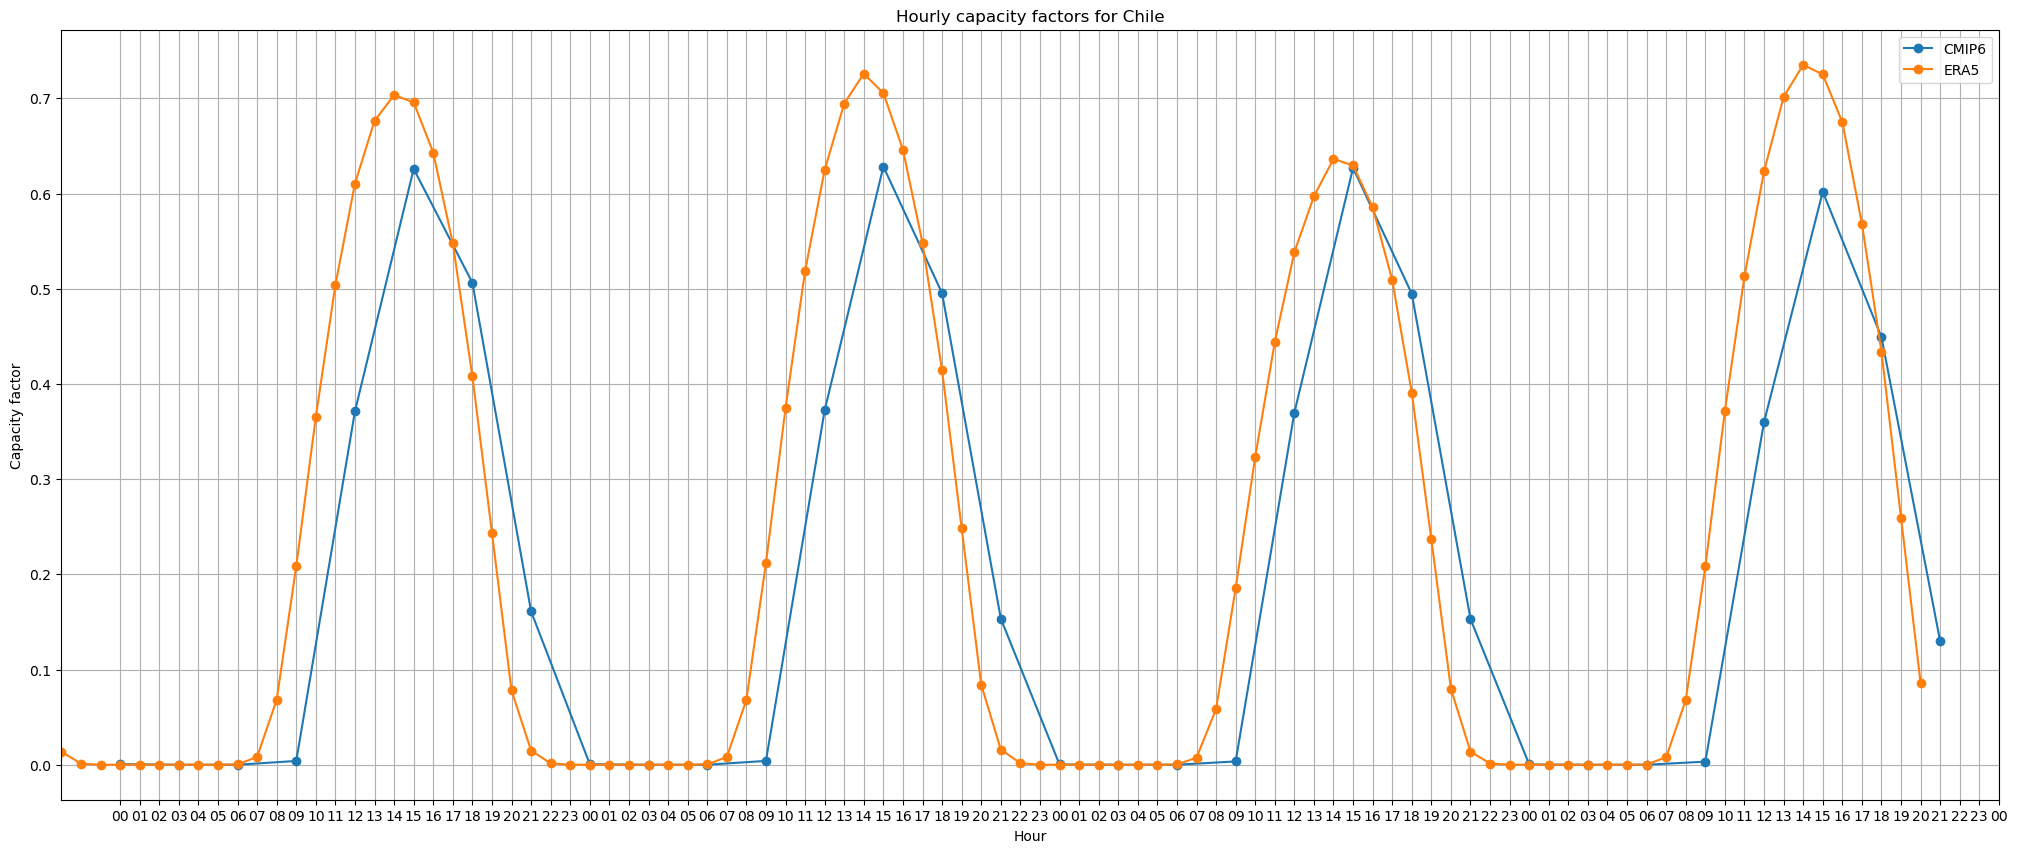

In [47]:
import datetime
# create xticks
xticks = pd.date_range(datetime.datetime(2021,12,30), datetime.datetime(2022,1,3), freq='1H')


fig, ax = plt.subplots(figsize=(25, 10))
df_cmip_chile_test.plot.line(ax=ax, marker='o', xticks=xticks.to_pydatetime(), grid=True)
df_era5_chile_test.plot.line(ax=ax, marker='o', xticks=xticks.to_pydatetime(), grid=True)
ax.set_xticklabels([x.strftime('%H') for x in xticks])
plt.title("Hourly PV capacity factors for Chile")
plt.xlabel("Hour")
plt.ylabel("Capacity factor")
plt.legend(["CMIP6", "ERA5"])

## WIND

In [136]:
# Obtaining roughness

roughness = cutout_era5_test.data["roughness"]

roughness = roughness.to_dataset()
da = roughness.interp_like(cutout_cmip_test.data['influx'].isel(time=0))
da = roughness.roughness.interp_like(cutout_cmip_test.data['influx'].isel(time=0))
cutout_cmip_test.data = cutout_cmip_test.data.assign(roughness=da)

# Calculating capacity factors

turbine_config = atlite.resource.get_windturbineconfig('Vestas_V112_3MW')

era5_cf_wind_mean_test, era5_cf_wind_test = cutout_era5_test.wind(turbine=turbine_config, capacity_factor=True)
cmip_cf_wind_mean_test, cmip_cf_wind_test = cutout_cmip_test.wind(turbine=turbine_config, capacity_factor=True)

# Capacity factor for Chile - average

era5_chile_test = era5_cf_wind_test.mean(["x","y"])
cmip_chile_test = cmip_cf_wind_test.mean(["x","y"])

# Converting xarray to data frame

df_era5_chile_test = era5_chile_test.to_pandas()
df_cmip_chile_test = cmip_chile_test.to_pandas()

# Converting from UTC to local time - ERA5

df_era5_chile_test.index = df_era5_chile_test.index.tz_localize("UTC")
df_era5_chile_test = df_era5_chile_test.tz_conver# Converting from UTC to local timet("America/Santiago")


### Plots

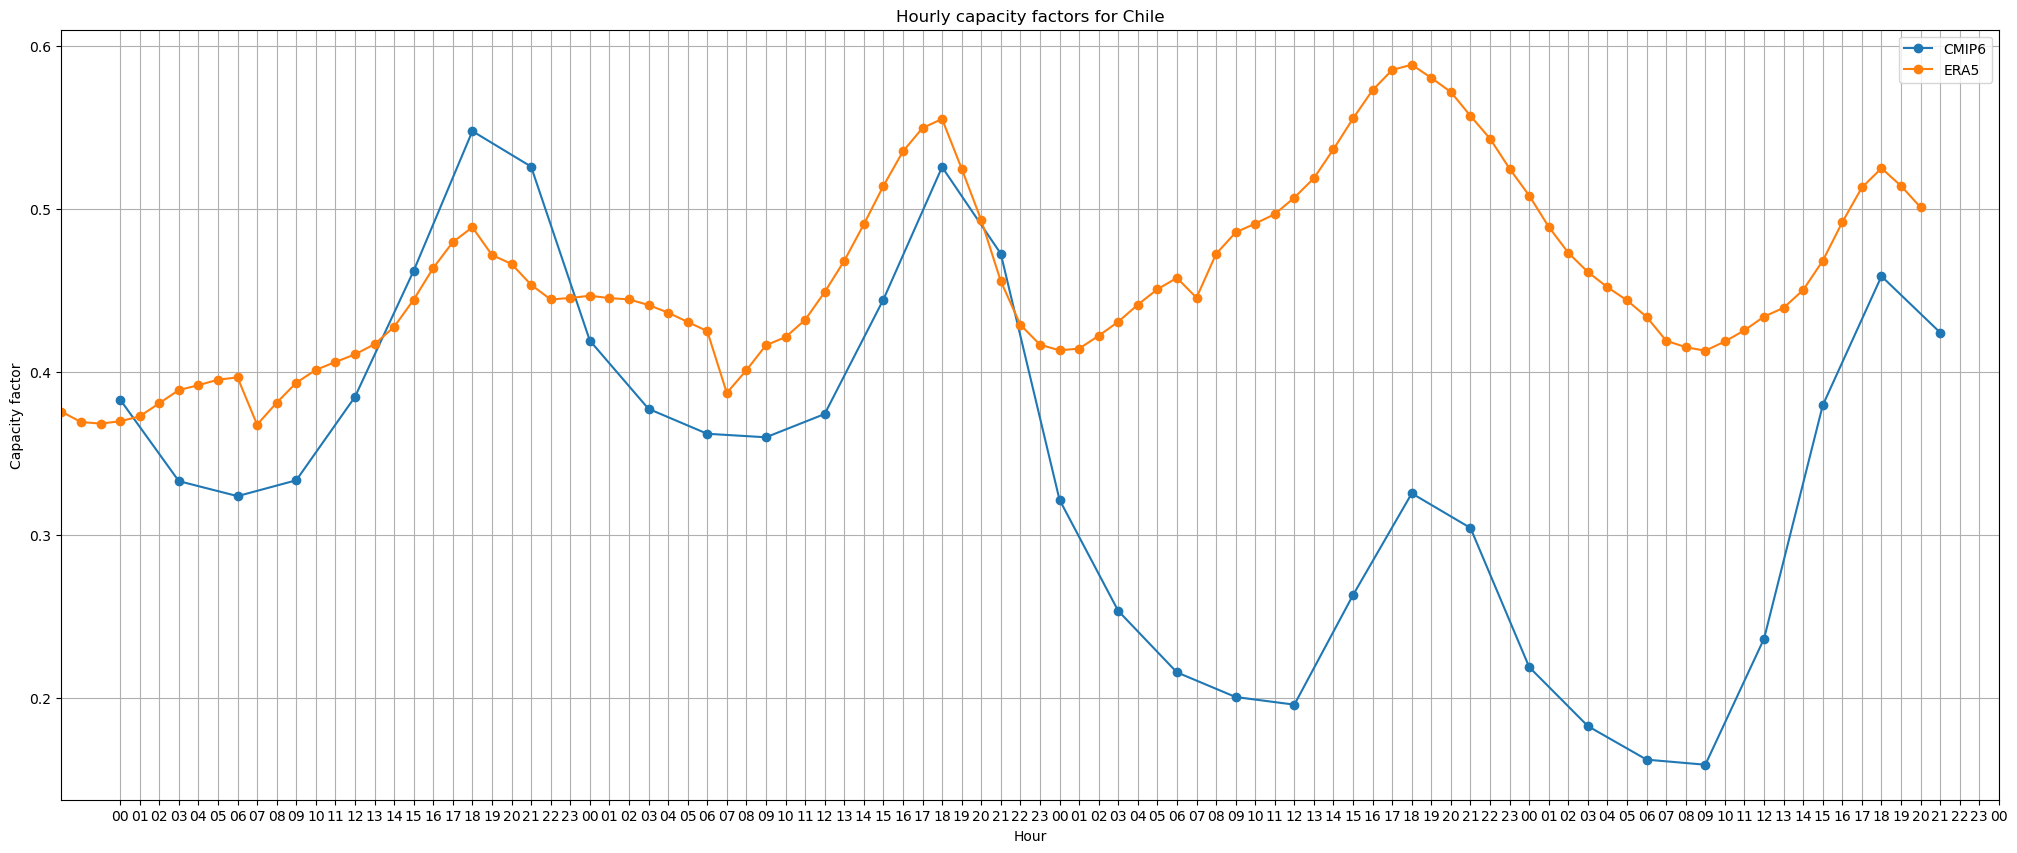

In [141]:
import datetime
# create xticks
xticks = pd.date_range(datetime.datetime(2021,12,30), datetime.datetime(2022,1,3), freq='1H')


fig, ax = plt.subplots(figsize=(25, 10))
df_cmip_chile_test.plot.line(ax=ax, marker='o', xticks=xticks.to_pydatetime(), grid=True)
df_era5_chile_test.plot.line(ax=ax, marker='o', xticks=xticks.to_pydatetime(), grid=True)
ax.set_xticklabels([x.strftime('%H') for x in xticks])
plt.title("Hourly wind capacity factors for Chile")
plt.xlabel("Hours")
plt.ylabel("Capacity factor")
plt.legend(["CMIP6", "ERA5"])